In [121]:
import numpy as np

from optyx.channel import *

In [122]:
ket_0 = zx.X(0, 1) @ optyx.Scalar(1 / np.sqrt(2))
Ket_0 = Channel('|0>', ket_0)

ket_1 = zx.X(0, 1, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Ket_1 = Channel('|1>', ket_1)

ket_plus = zx.Z(0, 1) @ optyx.Scalar(1 / np.sqrt(2))
Ket_plus = Channel('|+>', ket_plus)

ket_minus = zx.Z(0, 1, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Ket_minus = Channel('|->', ket_minus)

bra_0 = zx.X(1, 0) @ optyx.Scalar(1 / np.sqrt(2))
Bra_0 = Channel('<0|', bra_0)

bra_1 = zx.X(1, 0, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Bra_1 = Channel('<1|', bra_1)

bra_plus = zx.Z(1, 0) @ optyx.Scalar(1 / np.sqrt(2))
Bra_plus = Channel('<+|', bra_plus)

bra_minus = zx.Z(1, 0, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Bra_minus = Channel('<-|', bra_minus)

Bit_0 = Channel('<0|', bra_0, dom=bit)
Bit_1 = Channel('<1|', bra_1, dom=bit)


def diag_pow(diag, n):
    if n == 1:
        return diag
    return diag @ diag_pow(diag, n - 1)

In [123]:
logical_ket_00 = zx.Z(0, 4) @ optyx.Scalar(1 / np.sqrt(2))
Logical_ket_00 = Channel('|00>', logical_ket_00)

logical_bra_00 = zx.Z(4, 0) @ optyx.Scalar(1 / np.sqrt(2))
Logical_bra_00 = Channel('<00|', logical_bra_00)

In [124]:
x_detector = (
        (zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2))
        >> optyx.Diagram.permutation([0, 2, 4, 6, 1, 3, 5, 7], optyx.bit ** 8)
        >> optyx.Id(optyx.bit ** 4) @ zx.X(4, 1)
        @ zx.Scalar(np.sqrt(2) ** 3)
)
X_detector = Channel('X Error Detector', x_detector, dom=qubit ** 4, cod=qubit ** 4 @ bit)

In [125]:
z_detector = diag_pow(zx.H, 4) >> x_detector >> diag_pow(zx.H, 4) @ zx.Id(1)
Z_detector = Channel('Z Error Detector', z_detector, dom=qubit ** 4, cod=qubit ** 4 @ bit)

## Calculating the fidelity of Bell state in the post-selected [4,2,2] code, assuming perfect measurements

To calculate fidelity, we use
$$
P(<Bell| | S = 0) = \frac{P(<Bell| \land S = 0)}{P(S = 0)}
$$
where $S$ is the syndrome measurement.

### Using the encoder for the [4,2,2] code, we obtain the logical Bell state:

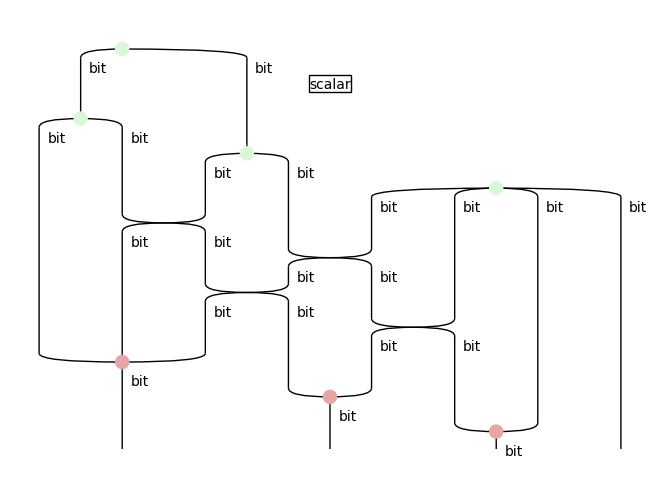

In [126]:
encoder = (
        zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(0, 4)
        >> optyx.Diagram.permutation([0,2,4,1,5,3,6,7], optyx.bit ** 8)
        >> zx.X(3,1) @ zx.X(2,1) @ zx.X(2,1) @ zx.Id(1)
)

logical_bell = zx.Z(0,2) @ zx.Scalar(2) >> encoder
logical_bell_measurement = logical_bell.dagger()

Logical_bell = Channel('|00> + |11>', logical_bell)
Logical_bell_measurement = Channel('<00| + <11|', logical_bell_measurement)

logical_bell.draw()

### Defining the circuit with probabilistic bit-flips on data qubits

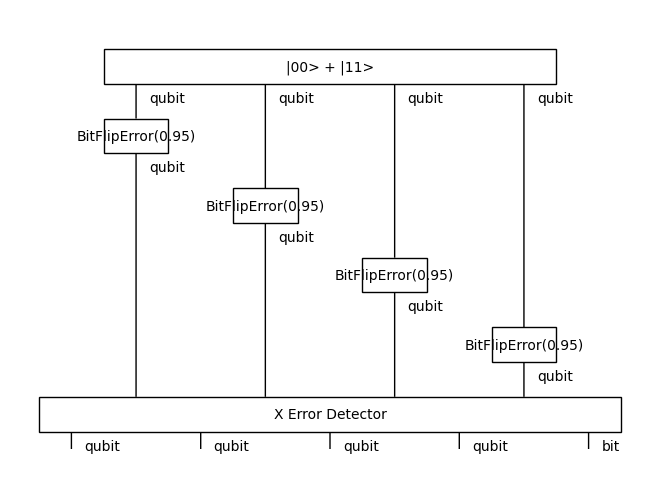

In [127]:
p_error = 0.95
Imperfect_circuit = Logical_bell >> diag_pow(BitFlipError(p_error), 4) >> X_detector

Imperfect_circuit.draw()

### Computing the fidelity after one round of X error detection

In [128]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity:", np.sqrt(fidelity).real)

Calculated fidelity: 0.9945355195789248


## Calculating the fidelity for the distributed [4,2,2] code with an imperfect Bell state on the network

### Defining the network Bell state from its density matrix

![Density Matrix](densityMatrix.png)

The state has a fidelity of 96.89(8)% to the |Ψ+⟩ Bell state.
https://www.nature.com/articles/s41586-024-08404-x

In [129]:
bell_density_re = np.array([
    [0.012, 0.014, 0.014, 0.000],
    [0.014, 0.508, 0.475, 0.008],
    [0.014, 0.475, 0.479, 0.009],
    [0.000, 0.008, 0.009, 0.000]
])
bell_density_im = np.exp(1j * np.pi * np.array([
    [0.000, -1.850, -1.825, -0.985],
    [1.850, 0.000, -0.002, -0.902],
    [1.825, 0.002, 0.000, -0.931],
    [0.985, 0.902, 0.931, 0.000]
]))

bell_density = np.multiply(bell_density_re, bell_density_im)
np.set_printoptions(precision=3)
print(bell_density)

[[ 0.012+0.j     0.012+0.006j  0.012+0.007j  0.   -0.j   ]
 [ 0.012-0.006j  0.508+0.j     0.475-0.003j -0.008-0.002j]
 [ 0.012-0.007j  0.475+0.003j  0.479+0.j    -0.009-0.002j]
 [-0.   +0.j    -0.008+0.002j -0.009+0.002j  0.   +0.j   ]]


In [130]:
from discopy import tensor

bell = optyx.Box(name="Bell", dom=optyx.bit ** 2, cod=optyx.bit ** 2)
bell.array = bell_density
bell.determine_output_dimensions = lambda input_dims: input_dims
bell.truncation = lambda input_dims, output_dims: tensor.Box("Bell", dom=tensor.Dim(2)**2, cod=tensor.Dim(2)**2, data=bell_density)
bell = optyx.Spider(0, 2, typ=optyx.bit) >> optyx.Id(optyx.bit) @ optyx.Spider(0, 2, typ=optyx.bit) @ optyx.Id(optyx.bit) >> optyx.Diagram.permutation([0,1,3,2], optyx.bit**4) >> optyx.Id(optyx.bit ** 2) @ bell >> optyx.Diagram.permutation([0,2,1,3], optyx.bit**4)

Noisy_bell = DensityMatrix('Physical Bell', bell, dom=Ty(), cod=qubit ** 2)

#### Verifying fidelity

In [131]:
Perfect_Bell_Effect = Channel("Perfect Bell Effect", optyx.Id(optyx.bit) @ zx.X(1,1,0.5) >> optyx.Spider(2,0,typ=optyx.bit) @ optyx.Scalar(1 / np.sqrt(2)))

print("Calculated fidelity:", (Noisy_bell >> Perfect_Bell_Effect).double().to_tensor().eval().array.real)

Calculated fidelity: 0.9684906239066646


### Defining the circuit for the distributed physical implementation

In [132]:
Imperfect_circuit = Logical_bell >> diag_pow(BitFlipError(p_error), 4) >> Physical_X_detector

P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity:", np.sqrt(fidelity.real))

Calculated fidelity: 0.983924765083915


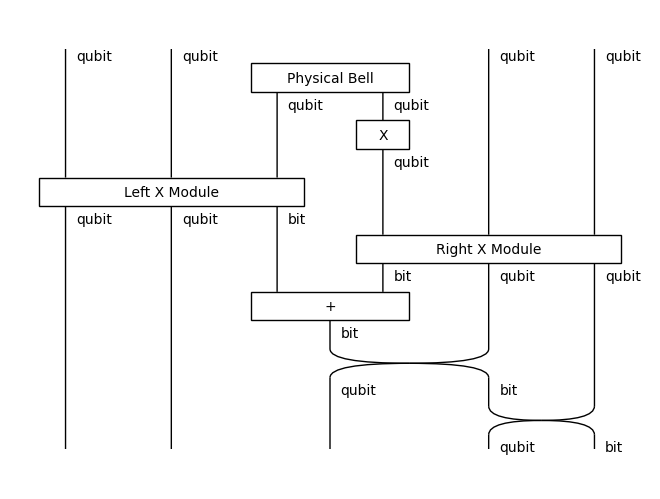

In [133]:
cnot = zx.Id(1) @ zx.X(1,2) >> zx.Z(2,1) @ zx.Id(1)
left_module = zx.Id(1) @ cnot >> optyx.Diagram.permutation([1, 0, 2], optyx.bit ** 3) >> zx.Id(1) @ cnot >> optyx.Diagram.permutation([1, 0, 2], optyx.bit ** 3)

notc = zx.X(1,2) @ zx.Id(1) >> zx.Id(1) @ zx.Z(2,1)
right_module = notc @ zx.Id(1) >> optyx.Diagram.permutation([0, 2, 1], optyx.bit ** 3) >> notc @ zx.Id(1) >> optyx.Diagram.permutation([0, 2, 1], optyx.bit ** 3)

X = Channel("X", zx.X(1,1,0.5))
Left_X_module = Channel("Left X Module", left_module, dom=qubit ** 3, cod=qubit ** 2 @ bit)
Right_X_module = Channel("Right X Module", right_module, dom=qubit ** 3, cod=bit @ qubit ** 2)

Left_Z_module = Channel(
    "Left Z Module", diag_pow(zx.H, 2) @ zx.Id(1) >> left_module >> diag_pow(zx.H, 2) @ zx.Id(1),
    dom=qubit ** 3, cod=qubit ** 2 @ bit)
Right_Z_module = Channel(
    "Right Z Module", zx.Id(1) @ diag_pow(zx.H, 2) >> right_module >> zx.Id(1) @ diag_pow(zx.H, 2),
    dom=qubit ** 3, cod=bit @ qubit ** 2)

ClassicalDetector = Channel("+", zx.X(2,1,0), dom=bit**2, cod=bit)

Physical_X_detector = Circuit.id(qubit ** 2) @ (Noisy_bell >> Circuit.id(qubit) @ X) @ Circuit.id(qubit ** 2) >> Left_X_module @ Right_X_module >> Circuit.id(qubit ** 2) @ ClassicalDetector @ Circuit.id(qubit ** 2) >> Circuit.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)

Physical_Z_detector = Circuit.id(qubit ** 2) @ (Noisy_bell >> Circuit.id(qubit) @ X) @ Circuit.id(qubit ** 2) >> Left_Z_module @ Right_Z_module >> Circuit.id(qubit ** 2) @ ClassicalDetector @ Circuit.id(qubit ** 2) >> Circuit.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)

Physical_X_detector.draw()

### Calculating fidelity for Z error detection

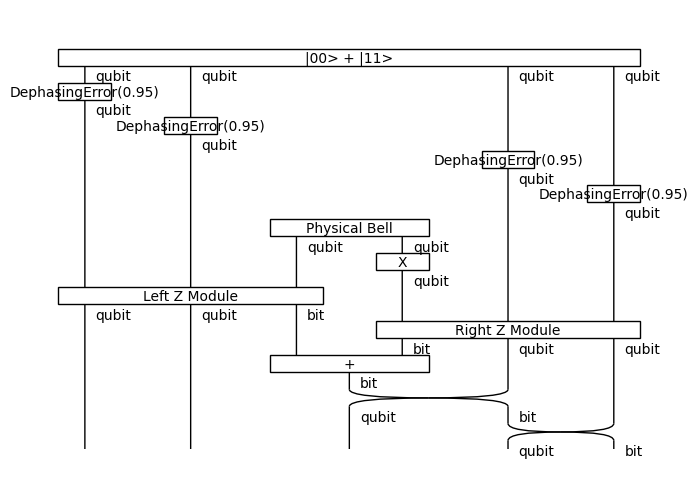

In [134]:
Imperfect_circuit = Logical_bell >> diag_pow(DephasingError(p_error), 4) >> Physical_Z_detector
Imperfect_circuit.draw()

In [135]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity for Z error detection:", np.sqrt(fidelity.real))

Calculated fidelity for Z error detection: 0.9839247650839149


### Calculating fidelity for a whole round of Z and X error detection

In [144]:
Imperfect_circuit = Logical_bell >> diag_pow(DephasingError(p_error), 4) >> Physical_Z_detector >> diag_pow(BitFlipError(p_error), 4) @ Circuit.id(bit) >> Physical_X_detector @ Circuit.id(bit)

P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", np.sqrt(fidelity.real))

Calculated fidelity a whole round of error detection: 0.9683118212658505
